<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/optuna_and_bayesian_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 8th July, 2021
# Myfolder: C:\Users\Administrator\OneDrive\Documents\breast_cancer
#
# Ref: https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258
#      https://github.com/optuna/optuna/blob/master/examples/lightgbm_tuner_simple.py
#
# Objective:
#           i) Learn to use automated tuning of lightgbm
#          ii) Using optuna
#         iii) Perform Bayesian optimization
#
# See also 'h2o_talkingData.ipynb' in folder:
#   C:\Users\Administrator\OneDrive\Documents\talkingdata

In [ ]:
"""
Optuna example that optimizes a classifier configuration
for cancer dataset using LightGBM tuner.
In this example, we optimize the validation log loss of
cancer detection.

"""

### Install libraries

In [ ]:
# 0.0 Optuna
#     https://optuna.org/
! pip install optuna

In [18]:
# 0.1 sklearn optimizer
# 
!pip install scikit-optimize
!pip install 'scikit-optimize[plots]'

     |████████████████████████████████| 102kB 5.6MB/s 


In [19]:
0.2 Lightgbm
! pip install lightgbm --upgrade
import lightgbm
lightgbm.__version__

0.1

     |████████████████████████████████| 2.0MB 8.7MB/s 
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


'2.2.3'

In [24]:
# 1.0 Call libraries
import pandas as pd
import numpy as np
import sklearn.datasets
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 1.1 Import optuna integration with lightgbm
# Install as: conda install -c conda-forge optuna

import optuna.integration.lightgbm as lgbm


# 1.2  Return stratified folds. The folds are made by
#      preserving the percentage of samples for each class.

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, roc_curve

# 1.3 ML - we will classify using lightgbm
#          with stratified cross validation
#      conda install -c conda-forge lightgbm 
import lightgbm as lgb

# 1.4 OS related
import os, time

# 1.5 Bayes optimization--IInd method
# SKOPT is a parameter-optimisation framewor
#  Install skopt as:
#     conda install -c conda-forge scikit-optimize


from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [25]:
# 1.6
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [26]:
# # 2.0 Get data and split it
data,target = make_classification( n_samples = 10000,
                          n_features = 20,
                          n_informative = 10,
                          n_redundant = 2,
                          n_repeated = 3,
                          n_classes = 2,
                          flip_y = 0.01,
                          shuffle = True)

# 2.0.1
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25)

In [27]:
# 2.1 Transform train_x and val_x to lightgbm data-matricies

dtrain = lgbm.Dataset(train_x, label=train_y)

dval = lgbm.Dataset(val_x, label=val_y)

In [28]:
# 3.0 Set fixed hyper-params
params_fixed = {                           # Specify params that are fixed
                 "objective": "binary",
                 "metric": "binary_logloss",
                 "verbosity": -1,
                 "boosting_type": "gbdt",
                }

In [29]:
# 3.1 Note that unlike in sklearn, here there is
#     no instantiation of LightGBM model
#     Start modeling as also tuning hyperparameters

model = lgbm.train(
                   params_fixed,               # Just fixed params only
                   dtrain,                     # Dataset
                   valid_sets=[dtrain, dval],  # Evaluate performance on these datasets
                   verbose_eval=100,
                   early_stopping_rounds=100
                  )


[I 2021-07-08 07:17:19,879] A new study created in memory with name: no-name-56b97d7f-1d9c-421a-8203-3da136ec2fc9
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0381096	valid_1's binary_logloss: 0.0997356
[200]	valid_0's binary_logloss: 0.00790182	valid_1's binary_logloss: 0.0913913


feature_fraction, val_score: 0.090753:  14%|#4        | 1/7 [00:00<00:05,  1.01it/s]

Early stopping, best iteration is:
[187]	valid_0's binary_logloss: 0.00958323	valid_1's binary_logloss: 0.0907532
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.030268	valid_1's binary_logloss: 0.0980822


feature_fraction, val_score: 0.090753:  14%|#4        | 1/7 [00:02<00:05,  1.01it/s]

[200]	valid_0's binary_logloss: 0.00537757	valid_1's binary_logloss: 0.0971241
Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.0130725	valid_1's binary_logloss: 0.095221


feature_fraction, val_score: 0.090753:  29%|##8       | 2/7 [00:02<00:05,  1.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0456781	valid_1's binary_logloss: 0.104454
[200]	valid_0's binary_logloss: 0.0104999	valid_1's binary_logloss: 0.0949056


feature_fraction, val_score: 0.090753:  43%|####2     | 3/7 [00:02<00:03,  1.03it/s]

Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.0147443	valid_1's binary_logloss: 0.0939922
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0253942	valid_1's binary_logloss: 0.0926768


feature_fraction, val_score: 0.089836:  57%|#####7    | 4/7 [00:04<00:03,  1.03s/it]

[200]	valid_0's binary_logloss: 0.00411341	valid_1's binary_logloss: 0.0939967
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.0120927	valid_1's binary_logloss: 0.089836


[I 2021-07-08 07:17:23,971] Trial 3 finished with value: 0.08983595021545777 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.08983595021545777.
feature_fraction, val_score: 0.089836:  57%|#####7    | 4/7 [00:04<00:03,  1.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0262574	valid_1's binary_logloss: 0.0945546


feature_fraction, val_score: 0.089836:  71%|#######1  | 5/7 [00:05<00:02,  1.04s/it]

[200]	valid_0's binary_logloss: 0.0042462	valid_1's binary_logloss: 0.0965736
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.0153669	valid_1's binary_logloss: 0.0923452
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0272739	valid_1's binary_logloss: 0.0952272


feature_fraction, val_score: 0.089836:  86%|########5 | 6/7 [00:06<00:01,  1.03s/it]

[200]	valid_0's binary_logloss: 0.00475885	valid_1's binary_logloss: 0.09748
Early stopping, best iteration is:
[128]	valid_0's binary_logloss: 0.0161695	valid_1's binary_logloss: 0.0917359
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0335499	valid_1's binary_logloss: 0.0998077
[200]	valid_0's binary_logloss: 0.00636738	valid_1's binary_logloss: 0.0950124
Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.012936	valid_1's binary_logloss: 0.0935982


num_leaves, val_score: 0.089836:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000872232	valid_1's binary_logloss: 0.100834


num_leaves, val_score: 0.089836:   5%|5         | 1/20 [00:02<00:45,  2.39s/it]

Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.00488303	valid_1's binary_logloss: 0.0941626
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000859301	valid_1's binary_logloss: 0.103425


num_leaves, val_score: 0.089836:  10%|#         | 2/20 [00:05<00:44,  2.46s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.00662219	valid_1's binary_logloss: 0.0986236
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000894184	valid_1's binary_logloss: 0.102005


num_leaves, val_score: 0.089836:  15%|#5        | 3/20 [00:08<00:46,  2.71s/it]

Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.00805191	valid_1's binary_logloss: 0.0964975
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000892441	valid_1's binary_logloss: 0.103233


num_leaves, val_score: 0.089836:  20%|##        | 4/20 [00:10<00:41,  2.60s/it]

Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.0072232	valid_1's binary_logloss: 0.0964949
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000881575	valid_1's binary_logloss: 0.102789


num_leaves, val_score: 0.089836:  25%|##5       | 5/20 [00:13<00:40,  2.68s/it]

Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.00483082	valid_1's binary_logloss: 0.09854
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.210931	valid_1's binary_logloss: 0.211966
[200]	valid_0's binary_logloss: 0.161594	valid_1's binary_logloss: 0.165865
[300]	valid_0's binary_logloss: 0.137583	valid_1's binary_logloss: 0.146607
[400]	valid_0's binary_logloss: 0.121598	valid_1's binary_logloss: 0.134001
[500]	valid_0's binary_logloss: 0.110385	valid_1's binary_logloss: 0.127547
[600]	valid_0's binary_logloss: 0.100681	valid_1's binary_logloss: 0.122694
[700]	valid_0's binary_logloss: 0.0927844	valid_1's binary_logloss: 0.119032
[800]	valid_0's binary_logloss: 0.0856343	valid_1's binary_logloss: 0.1168


num_leaves, val_score: 0.089836:  30%|###       | 6/20 [00:14<00:32,  2.30s/it]

[900]	valid_0's binary_logloss: 0.0796249	valid_1's binary_logloss: 0.115002
[1000]	valid_0's binary_logloss: 0.0744069	valid_1's binary_logloss: 0.113368
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.0744069	valid_1's binary_logloss: 0.113368
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00177761	valid_1's binary_logloss: 0.0972888


num_leaves, val_score: 0.089836:  35%|###5      | 7/20 [00:16<00:28,  2.16s/it]

Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.0048603	valid_1's binary_logloss: 0.0926778
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000961555	valid_1's binary_logloss: 0.0978426


num_leaves, val_score: 0.089836:  40%|####      | 8/20 [00:18<00:25,  2.15s/it]

Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.00573025	valid_1's binary_logloss: 0.0928019
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000885563	valid_1's binary_logloss: 0.0993031


num_leaves, val_score: 0.089836:  45%|####5     | 9/20 [00:21<00:25,  2.36s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.00320344	valid_1's binary_logloss: 0.0951931
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000869887	valid_1's binary_logloss: 0.103152


num_leaves, val_score: 0.089836:  50%|#####     | 10/20 [00:24<00:26,  2.61s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.0031317	valid_1's binary_logloss: 0.0973774
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00456264	valid_1's binary_logloss: 0.092611


num_leaves, val_score: 0.089836:  55%|#####5    | 11/20 [00:26<00:20,  2.30s/it]

Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.00570057	valid_1's binary_logloss: 0.0916611
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00407052	valid_1's binary_logloss: 0.0939652


num_leaves, val_score: 0.089836:  60%|######    | 12/20 [00:28<00:16,  2.06s/it]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.00741527	valid_1's binary_logloss: 0.0921721
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0077294	valid_1's binary_logloss: 0.0917921


num_leaves, val_score: 0.089836:  65%|######5   | 13/20 [00:29<00:13,  1.87s/it]

Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.00823243	valid_1's binary_logloss: 0.0914248
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0274458	valid_1's binary_logloss: 0.098487
[200]	valid_0's binary_logloss: 0.00481664	valid_1's binary_logloss: 0.0983063


num_leaves, val_score: 0.089836:  70%|#######   | 14/20 [00:30<00:09,  1.66s/it]

Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.012216	valid_1's binary_logloss: 0.0946959
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00569905	valid_1's binary_logloss: 0.0955812


num_leaves, val_score: 0.089836:  75%|#######5  | 15/20 [00:32<00:07,  1.58s/it]

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.0113977	valid_1's binary_logloss: 0.0941825
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00187871	valid_1's binary_logloss: 0.0982669


num_leaves, val_score: 0.089836:  80%|########  | 16/20 [00:33<00:06,  1.63s/it]

Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00625833	valid_1's binary_logloss: 0.0930093
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.093375	valid_1's binary_logloss: 0.116949
[200]	valid_0's binary_logloss: 0.0540213	valid_1's binary_logloss: 0.100839
[300]	valid_0's binary_logloss: 0.0336681	valid_1's binary_logloss: 0.0962595
[400]	valid_0's binary_logloss: 0.020851	valid_1's binary_logloss: 0.0939722
Early stopping, best iteration is:
[392]	valid_0's binary_logloss: 0.0215878	valid_1's binary_logloss: 0.0937886


num_leaves, val_score: 0.089836:  85%|########5 | 17/20 [00:34<00:04,  1.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0172843	valid_1's binary_logloss: 0.095012


num_leaves, val_score: 0.089836:  90%|######### | 18/20 [00:36<00:02,  1.39s/it]

Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.0176895	valid_1's binary_logloss: 0.094747
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00140044	valid_1's binary_logloss: 0.0994956


num_leaves, val_score: 0.089836:  95%|#########5| 19/20 [00:38<00:01,  1.55s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.0042924	valid_1's binary_logloss: 0.0946732
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00489343	valid_1's binary_logloss: 0.0952705


bagging, val_score: 0.089836:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.0113699	valid_1's binary_logloss: 0.0942736
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0271522	valid_1's binary_logloss: 0.0962813
[200]	valid_0's binary_logloss: 0.00489498	valid_1's binary_logloss: 0.094812
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.0137178	valid_1's binary_logloss: 0.0903724


bagging, val_score: 0.089836:  10%|#         | 1/10 [00:01<00:10,  1.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0245932	valid_1's binary_logloss: 0.0951481


bagging, val_score: 0.089836:  20%|##        | 2/10 [00:02<00:09,  1.23s/it]

[200]	valid_0's binary_logloss: 0.00402044	valid_1's binary_logloss: 0.0967322
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.0134399	valid_1's binary_logloss: 0.0923883
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0272501	valid_1's binary_logloss: 0.0968569
[200]	valid_0's binary_logloss: 0.00480428	valid_1's binary_logloss: 0.0961106


bagging, val_score: 0.089836:  30%|###       | 3/10 [00:03<00:08,  1.25s/it]

Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.0102911	valid_1's binary_logloss: 0.0931523
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0252921	valid_1's binary_logloss: 0.0962923
[200]	valid_0's binary_logloss: 0.00390208	valid_1's binary_logloss: 0.0955578


bagging, val_score: 0.089836:  40%|####      | 4/10 [00:05<00:07,  1.27s/it]

Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.0101101	valid_1's binary_logloss: 0.0913045
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0258786	valid_1's binary_logloss: 0.0949673


bagging, val_score: 0.089836:  50%|#####     | 5/10 [00:06<00:06,  1.23s/it]

[200]	valid_0's binary_logloss: 0.0041623	valid_1's binary_logloss: 0.098005
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.0198223	valid_1's binary_logloss: 0.0929572
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0255833	valid_1's binary_logloss: 0.0956603


bagging, val_score: 0.089836:  60%|######    | 6/10 [00:07<00:04,  1.23s/it]

[200]	valid_0's binary_logloss: 0.00450406	valid_1's binary_logloss: 0.0993965
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.01258	valid_1's binary_logloss: 0.0927104


[I 2021-07-08 07:18:13,904] Trial 32 finished with value: 0.09271044684137764 and parameters: {'bagging_fraction': 0.6492720956953384, 'bagging_freq': 5}. Best is trial 27 with value: 0.09037235019307102.
bagging, val_score: 0.089836:  60%|######    | 6/10 [00:07<00:04,  1.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0258653	valid_1's binary_logloss: 0.0939667


bagging, val_score: 0.089836:  70%|#######   | 7/10 [00:08<00:03,  1.21s/it]

[200]	valid_0's binary_logloss: 0.00466057	valid_1's binary_logloss: 0.0971842
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.0137098	valid_1's binary_logloss: 0.0924442
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0281999	valid_1's binary_logloss: 0.0996069


bagging, val_score: 0.089836:  80%|########  | 8/10 [00:09<00:02,  1.18s/it]

[200]	valid_0's binary_logloss: 0.00542598	valid_1's binary_logloss: 0.100059
Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.0189714	valid_1's binary_logloss: 0.0970098
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0256515	valid_1's binary_logloss: 0.0939244
[200]	valid_0's binary_logloss: 0.00419583	valid_1's binary_logloss: 0.0949619


bagging, val_score: 0.089836:  90%|######### | 9/10 [00:10<00:01,  1.19s/it]

Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.0108052	valid_1's binary_logloss: 0.0908733
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0299968	valid_1's binary_logloss: 0.0988773
[200]	valid_0's binary_logloss: 0.00558022	valid_1's binary_logloss: 0.101086


feature_fraction_stage2, val_score: 0.089836:   0%|          | 0/3 [00:00<?, ?it/s]

Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.0141744	valid_1's binary_logloss: 0.0961212
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0253942	valid_1's binary_logloss: 0.0926768


feature_fraction_stage2, val_score: 0.089836:   0%|          | 0/3 [00:01<?, ?it/s]

[200]	valid_0's binary_logloss: 0.00411341	valid_1's binary_logloss: 0.0939967
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.0120927	valid_1's binary_logloss: 0.089836


feature_fraction_stage2, val_score: 0.089836:  33%|###3      | 1/3 [00:01<00:02,  1.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0266999	valid_1's binary_logloss: 0.0955665
[200]	valid_0's binary_logloss: 0.00452384	valid_1's binary_logloss: 0.0959887


feature_fraction_stage2, val_score: 0.089836:  67%|######6   | 2/3 [00:02<00:01,  1.17s/it]

Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.0114996	valid_1's binary_logloss: 0.0921799
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0262574	valid_1's binary_logloss: 0.0945546


regularization_factors, val_score: 0.089836:   0%|          | 0/20 [00:00<?, ?it/s]

[200]	valid_0's binary_logloss: 0.0042462	valid_1's binary_logloss: 0.0965736
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.0153669	valid_1's binary_logloss: 0.0923452
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0259698	valid_1's binary_logloss: 0.0963468


regularization_factors, val_score: 0.089836:   5%|5         | 1/20 [00:01<00:24,  1.31s/it]

[200]	valid_0's binary_logloss: 0.00443343	valid_1's binary_logloss: 0.0984468
Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.015929	valid_1's binary_logloss: 0.0936962
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0253943	valid_1's binary_logloss: 0.0926768
[200]	valid_0's binary_logloss: 0.00411345	valid_1's binary_logloss: 0.0939967


regularization_factors, val_score: 0.089836:  10%|#         | 2/20 [00:02<00:23,  1.33s/it]

Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.0120928	valid_1's binary_logloss: 0.0898359
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.030656	valid_1's binary_logloss: 0.0950943
[200]	valid_0's binary_logloss: 0.0100051	valid_1's binary_logloss: 0.0925467
Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.0135703	valid_1's binary_logloss: 0.0916565


regularization_factors, val_score: 0.089836:  15%|#5        | 3/20 [00:04<00:22,  1.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0268025	valid_1's binary_logloss: 0.095615
[200]	valid_0's binary_logloss: 0.00448251	valid_1's binary_logloss: 0.0995365


regularization_factors, val_score: 0.089836:  20%|##        | 4/20 [00:05<00:21,  1.34s/it]

Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.0135581	valid_1's binary_logloss: 0.0939104
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0253942	valid_1's binary_logloss: 0.0926768
[200]	valid_0's binary_logloss: 0.00411342	valid_1's binary_logloss: 0.0939967


regularization_factors, val_score: 0.089836:  25%|##5       | 5/20 [00:06<00:20,  1.34s/it]

Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.0120927	valid_1's binary_logloss: 0.0898359
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0577284	valid_1's binary_logloss: 0.103592
[200]	valid_0's binary_logloss: 0.0279431	valid_1's binary_logloss: 0.0959309
[300]	valid_0's binary_logloss: 0.0167659	valid_1's binary_logloss: 0.0958183


regularization_factors, val_score: 0.089836:  30%|###       | 6/20 [00:08<00:21,  1.52s/it]

Early stopping, best iteration is:
[261]	valid_0's binary_logloss: 0.0200361	valid_1's binary_logloss: 0.0951008
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.026806	valid_1's binary_logloss: 0.0956154


regularization_factors, val_score: 0.089836:  35%|###5      | 7/20 [00:09<00:18,  1.45s/it]

[200]	valid_0's binary_logloss: 0.00452292	valid_1's binary_logloss: 0.0980174
Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.0164483	valid_1's binary_logloss: 0.0936407
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0253626	valid_1's binary_logloss: 0.0944646
[200]	valid_0's binary_logloss: 0.00408028	valid_1's binary_logloss: 0.0974187
Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.0129444	valid_1's binary_logloss: 0.092903


regularization_factors, val_score: 0.089836:  40%|####      | 8/20 [00:11<00:17,  1.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0328356	valid_1's binary_logloss: 0.0942387
[200]	valid_0's binary_logloss: 0.0115642	valid_1's binary_logloss: 0.0911474


regularization_factors, val_score: 0.089836:  45%|####5     | 9/20 [00:12<00:15,  1.41s/it]

Early stopping, best iteration is:
[191]	valid_0's binary_logloss: 0.0123953	valid_1's binary_logloss: 0.0909128
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0538335	valid_1's binary_logloss: 0.100196
[200]	valid_0's binary_logloss: 0.0237895	valid_1's binary_logloss: 0.0943328
[300]	valid_0's binary_logloss: 0.0130951	valid_1's binary_logloss: 0.0933197


regularization_factors, val_score: 0.089836:  50%|#####     | 10/20 [00:14<00:16,  1.64s/it]

Early stopping, best iteration is:
[286]	valid_0's binary_logloss: 0.0140743	valid_1's binary_logloss: 0.0930816
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0268018	valid_1's binary_logloss: 0.0956149
[200]	valid_0's binary_logloss: 0.00442726	valid_1's binary_logloss: 0.0983188


regularization_factors, val_score: 0.089836:  55%|#####5    | 11/20 [00:16<00:14,  1.57s/it]

Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.0112925	valid_1's binary_logloss: 0.0931024
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0253942	valid_1's binary_logloss: 0.0926768
[200]	valid_0's binary_logloss: 0.00411341	valid_1's binary_logloss: 0.0939967


regularization_factors, val_score: 0.089836:  60%|######    | 12/20 [00:17<00:12,  1.51s/it]

Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.0120927	valid_1's binary_logloss: 0.089836
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0253945	valid_1's binary_logloss: 0.0926768
[200]	valid_0's binary_logloss: 0.0041137	valid_1's binary_logloss: 0.0939962


regularization_factors, val_score: 0.089836:  65%|######5   | 13/20 [00:19<00:10,  1.47s/it]

Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.012093	valid_1's binary_logloss: 0.0898359
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0253947	valid_1's binary_logloss: 0.0926768
[200]	valid_0's binary_logloss: 0.00411385	valid_1's binary_logloss: 0.093996


regularization_factors, val_score: 0.089836:  70%|#######   | 14/20 [00:20<00:08,  1.45s/it]

Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.0120932	valid_1's binary_logloss: 0.0898359
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0254101	valid_1's binary_logloss: 0.0966377


regularization_factors, val_score: 0.089836:  75%|#######5  | 15/20 [00:21<00:06,  1.39s/it]

[200]	valid_0's binary_logloss: 0.00455905	valid_1's binary_logloss: 0.0987355
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.0201865	valid_1's binary_logloss: 0.0953622
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0268019	valid_1's binary_logloss: 0.0956392
[200]	valid_0's binary_logloss: 0.00442742	valid_1's binary_logloss: 0.0983273


regularization_factors, val_score: 0.089836:  80%|########  | 16/20 [00:23<00:05,  1.40s/it]

Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.0112926	valid_1's binary_logloss: 0.0931147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0261429	valid_1's binary_logloss: 0.0972692
[200]	valid_0's binary_logloss: 0.00442588	valid_1's binary_logloss: 0.0996465


regularization_factors, val_score: 0.089836:  85%|########5 | 17/20 [00:24<00:04,  1.40s/it]

Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.011312	valid_1's binary_logloss: 0.0942822
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0257536	valid_1's binary_logloss: 0.0985693
[200]	valid_0's binary_logloss: 0.00439922	valid_1's binary_logloss: 0.100248


regularization_factors, val_score: 0.089836:  90%|######### | 18/20 [00:25<00:02,  1.40s/it]

Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.0127461	valid_1's binary_logloss: 0.095884
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0253943	valid_1's binary_logloss: 0.0926768
[200]	valid_0's binary_logloss: 0.00411352	valid_1's binary_logloss: 0.0939965


regularization_factors, val_score: 0.089836:  95%|#########5| 19/20 [00:27<00:01,  1.39s/it]

Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.0120928	valid_1's binary_logloss: 0.0898359
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0253946	valid_1's binary_logloss: 0.0926769
[200]	valid_0's binary_logloss: 0.00411385	valid_1's binary_logloss: 0.0939961


min_data_in_leaf, val_score: 0.089836:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.0120931	valid_1's binary_logloss: 0.089836
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0242783	valid_1's binary_logloss: 0.0970875


min_data_in_leaf, val_score: 0.089836:  20%|##        | 1/5 [00:01<00:05,  1.37s/it]

[200]	valid_0's binary_logloss: 0.00396737	valid_1's binary_logloss: 0.100779
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.0136264	valid_1's binary_logloss: 0.0952047


[I 2021-07-08 07:18:52,092] Trial 60 finished with value: 0.09520474107229336 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 0.09520474107229336.
min_data_in_leaf, val_score: 0.089836:  20%|##        | 1/5 [00:01<00:05,  1.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0235292	valid_1's binary_logloss: 0.096362


min_data_in_leaf, val_score: 0.089836:  40%|####      | 2/5 [00:02<00:04,  1.36s/it]

[200]	valid_0's binary_logloss: 0.00389642	valid_1's binary_logloss: 0.0990119
Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.0223279	valid_1's binary_logloss: 0.0957276
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0332724	valid_1's binary_logloss: 0.0943157
[200]	valid_0's binary_logloss: 0.00625863	valid_1's binary_logloss: 0.0941238


min_data_in_leaf, val_score: 0.089836:  60%|######    | 3/5 [00:03<00:02,  1.32s/it]

Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.0154447	valid_1's binary_logloss: 0.0905211
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0284007	valid_1's binary_logloss: 0.0977881
[200]	valid_0's binary_logloss: 0.00491651	valid_1's binary_logloss: 0.0982477


min_data_in_leaf, val_score: 0.089836:  80%|########  | 4/5 [00:05<00:01,  1.32s/it]

Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.0120501	valid_1's binary_logloss: 0.095798
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0260306	valid_1's binary_logloss: 0.0950447


min_data_in_leaf, val_score: 0.089836: 100%|##########| 5/5 [00:06<00:00,  1.30s/it]

[200]	valid_0's binary_logloss: 0.00428766	valid_1's binary_logloss: 0.0971265
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.0197392	valid_1's binary_logloss: 0.0933042


In [31]:
# 3.2 This predicts probabilities:
model.predict(
                val_x,    # Note that it is not lightgbm dataset
                num_iteration = model.best_iteration
             )

array([9.90719887e-01, 9.90108305e-01, 1.17905424e-03, ...,
       4.93418061e-04, 2.71868461e-02, 9.79997092e-03])

In [30]:
### Model is ready
# 4.0 Make prediction
#     np.rint: Round elements of the array to the nearest integer. 
#     For values exactly halfway between rounded decimal values,
#     NumPy rounds to the nearest even value. Thus 1.5 and 2.5 
#     round to 2.0, -0.5 and 0.5 round to 0.0, etc.

prediction = np.rint(
                     model.predict(
                                    val_x,    # Note that it is not lightgbm dataset
                                    num_iteration = model.best_iteration
                                    )
                    )

# 4.0.1
prediction

array([1., 1., 0., ..., 0., 0., 0.])

In [32]:
# 4.1 Determine accuracy
accuracy = accuracy_score(val_y, prediction)

# 4.2 Get best params
best_params = model.params
print("\nbest_params: " ,best_params) 
print("\n===============")
print("\nAccuracy: ", accuracy)
print("\n===============")

# 4.3
for key, value in best_params.items():
    print("\n    {}: {}".format(key, value))

######################



best_params:  {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 4.066584328323084e-06, 'lambda_l2': 3.9096804408098115e-05, 'num_leaves': 31, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 100}


Accuracy:  0.9736


    objective: binary

    metric: binary_logloss

    verbosity: -1

    boosting_type: gbdt

    feature_pre_filter: False

    lambda_l1: 4.066584328323084e-06

    lambda_l2: 3.9096804408098115e-05

    num_leaves: 31

    feature_fraction: 1.0

    bagging_fraction: 1.0

    bagging_freq: 0

    min_child_samples: 20

    num_iterations: 1000

    early_stopping_round: 100


## Bayesian optimization

#### Model Object

In [33]:
# 5.0. Define classifier object:

model_lgb = lgb.LGBMRegressor(                # Regressor will also perform classification
                                objective='binary',
                                metric='auc', # This output must match with what
                                          #  we specify as input to Bayesian model
                                n_jobs=2,
                                verbose=0,
                                #baggeng_freq=1,
                                #bagging_fraction =0.8,
                              )

#### Parameter space

In [34]:
# 5.1 Parameter search space for selected modeler
#      For suggested parameter grid for lightgbm, pl see: 
#         https://github.com/Microsoft/LightGBM/issues/695
#
params = {
        # The 'boosting' option parameter give lots of errors. 
        # Do not use it. (Removed 'rf' from it. Avoids errors)
        'boosting'    :   Categorical(['gbdt','dart']),                                                         
        'n_estimators':   Integer(50, 100), # No of boosted trees or iterations to fit (default: 100).

        'num_leaves'  :   Integer(5,45),   # Max tree leaves for base boosters
                                           # Create a node only if no of leaves exceed this limit
                                           #  and also following condition of 'min_child_samples' is met

        'min_child_samples': Integer(1, 50),  # Create a node only if min data-points at this node
                                              #  exceed this limit

        'feature_fraction' : Real(0.1, 0.9),  # Randomly select part of features on each iteration
                                              #  for every boosted tree

        'bagging_fraction' : Real(0.8, 1),   # Randomly select part of data without resampling
                                             #   for each boosted tree

        'bagging_freq'     : Integer(1,10),  # k means perform bagging at every k iteration

        'max_depth'        : Integer(1, 50), # Max tree depth for base learners, -1 means no limit.

        'learning_rate': Real(0.01, 1.0, 'log-uniform'), # Prob of interval 1 to 10 is same as 10 to 100
                                                         # Equal prob of selection from 0.01 to 0.1, 0.1
                                                         # to 1
                                                         # In a loguniform distributon, log-transformed
                                                         # random variable is uniformly distributed

        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),  # L2 regularization term on weights.
        'reg_alpha':  Real(1e-9, 1.0, 'log-uniform'),   #  L1 regularization

        'scale_pos_weight': Real(1, 10),    # default: 1
                                            # used only in binary application
                                            # How much more importance should be given to binary
                                            # weight of labels with positive class

        #-----***** Not understood **** -----

        'max_bin': Integer(100, 1000),      # max number of bins that feature
                                            #  values will be bucketed in
                                            # small number of bins may reduce
                                            # training accuracy but may increase
                                            # general power (deal with over-fitting)

        'min_child_weight':  Real(1, 10),   # Deals with overfitting

        'subsample_for_bin': Integer(100000, 500000)  #  Number of samples for constructing bins(default: 200000)
                                               # setting this to larger value will give better training
                                               #  result, but will increase data loading time
           }



#### Cross validation strategy

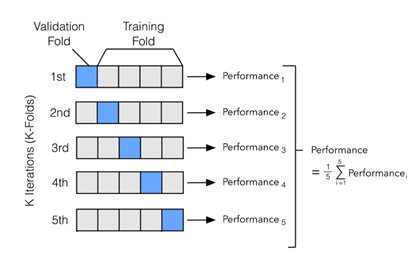

In [35]:
# 5.2 Cross validation strategy for the modeler
#      Perform startified k-fold cross-validation
#      There is also RepeatedStratifiedKFold() class
#      that will repeat startified k-fold N-number
#      of times
#      Instantiate cross-vlidation object
"""
Examples of Cross-validation strategies:
    i)   Leave one out  : Very time consuming
    ii)  Leave P out    : For example, leave 2 out
    iii) kfold          : k-equal random folds
    iv)  StratifiedKFold : kfolds + stratification
    v)   ShuffleSplit  => Generate n-numbers of userdefined pairs
                          of (train,test). For examples, in each
                          (train,test) pair, let number of rows
                          of 'test' data be 30% of train data

"""

cvStrategy = StratifiedKFold(
                             n_splits=3,
                             shuffle=True,
                             random_state=42
                            )

"\nExamples of Cross-validation strategies:\n    i)   Leave one out  : Very time consuming\n    ii)  Leave P out    : For example, leave 2 out\n    iii) kfold          : k-equal random folds\n    iv)  StratifiedKFold : kfolds + stratification\n    v)   ShuffleSplit  => Generate n-numbers of userdefined pairs\n                          of (train,test). For examples, in each\n                          (train,test) pair, let number of rows\n                          of 'test' data be 30% of train data\n\n"

#### Bayes tuner object

In [36]:
# 5.3 Bayesian object instantiation
#     For API, refer: https://scikit-optimize.github.io/#skopt.BayesSearchCV
#     For example: https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

start = time.time()
bayes_cv_tuner = BayesSearchCV(
                              estimator = model_lgb,    # rf, lgb, xgb, nn , pipeline etc--Black box
                              search_spaces = params,  # Specify params as required by the estimator
                              scoring = 'roc_auc',  # Input to Bayes function
                                                    # modeler should return this
                                                    # peformence metric
                              cv = cvStrategy,      # Optional. Determines the cross-validation splitting strategy.
                                                    #           Can be cross-validation generator or an iterable,
                                                    #           Possible inputs for cv are: - None, to use the default 3-fold cv,
                                                    #           - integer, to specify the number of folds in a (Stratified)KFold,
                                                    #           - An object to be used as a cross-validation generator.
                              n_jobs = 2,           # Start two parallel threads for processing
                              n_iter = 10,        # How many times to look for parameter sets
                              verbose = 1,
                              refit = True,       #  Refit the best estimator with the entire dataset
                              random_state = 42
                               )
end = time.time()
(end-start)/60

#### Begin tuning

In [38]:
# 5.4 Start learning using Bayes tuner

start = time.time()
result = bayes_cv_tuner.fit(
                            train_x,       # Note that we use normal train data
                            train_y       #  rather than lgb train-data matrix
                           #callback=status_print
                           )

end = time.time()
(end - start)/60


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   44.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    9.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    8.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    9.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    9.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    6.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    2.7s finished


[LightGBM] [Warning] bagging_fraction is set=0.9234158717004632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9234158717004632
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7994602362675662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7994602362675662
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9234158717004632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9234158717004632
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7994602362675662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7994602362675662
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignor

1.7050672968228657

#### Results

In [ ]:
# 6.0 So what are the results?
#      Use the following estimator in future
#      What parameters the best estimator was using?

best_params = pd.Series(bayes_cv_tuner.best_params_)
print(best_params)

# 6.1 Best auc score for the above estimator

print("\n\nBest score: ", np.round(bayes_cv_tuner.best_score_, 4))


In [40]:
# 6.2 Summary of all models developed by Bayes process

allModels_summary = pd.DataFrame(bayes_cv_tuner.cv_results_)
allModels_summary.shape  # 50 X 26 ; 50 iterations

# 17.3
allModels_summary.head()

(10, 26)

,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bagging_fraction,param_bagging_freq,param_boosting,param_feature_fraction,param_learning_rate,param_max_bin,param_max_depth,param_min_child_samples,param_min_child_weight,param_n_estimators,param_num_leaves,param_reg_alpha,param_reg_lambda,param_scale_pos_weight,param_subsample_for_bin,params
0,0.988982,0.987655,0.987402,0.988013,0.000693,4,28.441240,19.930946,0.025239,0.008256,0.882021,8,gbdt,0.352640,0.218925,473,18,37,3.740170,82,27,1.385174e-08,1.370904e-07,6.688861,131156,"{'bagging_fraction': 0.8820207917706628, 'bagg..."
1,0.990606,0.987696,0.986857,0.988386,0.001607,2,5.657794,3.760303,0.024961,0.007852,0.967478,9,dart,0.860979,0.534879,156,8,18,6.721562,98,30,8.524050e-01,1.590337e+00,4.496724,342928,"{'bagging_fraction': 0.9674776711106569, 'bagg..."
2,0.979032,0.975995,0.978529,0.977852,0.001329,9,6.003815,3.912243,0.024276,0.007369,0.888967,9,dart,0.446666,0.023763,508,9,38,6.016064,99,33,2.711809e-06,2.367361e-07,5.585960,278139,"{'bagging_fraction': 0.8889665024602303, 'bagg..."
3,0.990094,0.986936,0.987576,0.988202,0.001363,3,0.356219,0.147289,0.019463,0.007358,0.962479,3,gbdt,0.742212,0.111200,186,38,44,9.207360,69,19,3.449623e-02,2.114410e-02,1.236578,485880,"{'bagging_fraction': 0.9624791976714727, 'bagg..."
4,0.989252,0.987627,0.985639,0.987506,0.001478,5,5.248043,3.533455,0.019700,0.006454,0.959911,5,gbdt,0.672571,0.642250,745,22,33,4.177755,83,26,8.740059e-02,1.165902e-06,3.383559,207155,"{'bagging_fraction': 0.9599106883214347, 'bagg..."


In [ ]:
####### I am done #############